In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
from __future__ import division
import numpy as np
from scipy.spatial import cKDTree as KDTree
    # http://docs.scipy.org/doc/scipy/reference/spatial.html

__date__ = "2010-11-09 Nov"  # weights, doc

#...............................................................................
class Invdisttree:
    """ inverse-distance-weighted interpolation using KDTree:
invdisttree = Invdisttree( X, z )  -- data points, values
interpol = invdisttree( q, nnear=3, eps=0, p=1, weights=None, stat=0 )
    interpolates z from the 3 points nearest each query point q;
    For example, interpol[ a query point q ]
    finds the 3 data points nearest q, at distances d1 d2 d3
    and returns the IDW average of the values z1 z2 z3
        (z1/d1 + z2/d2 + z3/d3)
        / (1/d1 + 1/d2 + 1/d3)
        = .55 z1 + .27 z2 + .18 z3  for distances 1 2 3
    q may be one point, or a batch of points.
    eps: approximate nearest, dist <= (1 + eps) * true nearest
    p: use 1 / distance**p
    weights: optional multipliers for 1 / distance**p, of the same shape as q
    stat: accumulate wsum, wn for average weights
How many nearest neighbors should one take ?
a) start with 8 11 14 .. 28 in 2d 3d 4d .. 10d; see Wendel's formula
b) make 3 runs with nnear= e.g. 6 8 10, and look at the results --
    |interpol 6 - interpol 8| etc., or |f - interpol*| if you have f(q).
    I find that runtimes don't increase much at all with nnear -- ymmv.
p=1, p=2 ?
    p=2 weights nearer points more, farther points less.
    In 2d, the circles around query points have areas ~ distance**2,
    so p=2 is inverse-area weighting. For example,
        (z1/area1 + z2/area2 + z3/area3)
        / (1/area1 + 1/area2 + 1/area3)
        = .74 z1 + .18 z2 + .08 z3  for distances 1 2 3
    Similarly, in 3d, p=3 is inverse-volume weighting.
Scaling:
    if different X coordinates measure different things, Euclidean distance
    can be way off.  For example, if X0 is in the range 0 to 1
    but X1 0 to 1000, the X1 distances will swamp X0;
    rescale the data, i.e. make X0.std() ~= X1.std() .
A nice property of IDW is that it's scale-free around query points:
if I have values z1 z2 z3 from 3 points at distances d1 d2 d3,
the IDW average
    (z1/d1 + z2/d2 + z3/d3)
    / (1/d1 + 1/d2 + 1/d3)
is the same for distances 1 2 3, or 10 20 30 -- only the ratios matter.
In contrast, the commonly-used Gaussian kernel exp( - (distance/h)**2 )
is exceedingly sensitive to distance and to h.
    """
# anykernel( dj / av dj ) is also scale-free
# error analysis, |f(x) - idw(x)| ? todo: regular grid, nnear ndim+1, 2*ndim

    def __init__( self, X, z, leafsize=10, stat=0 ):
        assert len(X) == len(z), "len(X) %d != len(z) %d" % (len(X), len(z))
        self.tree = KDTree( X, leafsize=leafsize )  # build the tree
        self.z = z
        self.stat = stat
        self.wn = 0
        self.wsum = None;

    def __call__( self, q, nnear=6, eps=0, p=1, weights=None ):
            # nnear nearest neighbours of each query point --
        q = np.asarray(q)
        qdim = q.ndim
        if qdim == 1:
            q = np.array([q])
        if self.wsum is None:
            self.wsum = np.zeros(nnear)

        self.distances, self.ix = self.tree.query( q, k=nnear, eps=eps )
        interpol = np.zeros( (len(self.distances),) + np.shape(self.z[0]) )
        jinterpol = 0
        for dist, ix in zip( self.distances, self.ix ):
            if nnear == 1:
                wz = self.z[ix]
            elif dist[0] < 1e-10:
                wz = self.z[ix[0]]
            else:  # weight z s by 1/dist --
                w = 1 / dist**p
                if weights is not None:
                    w *= weights[ix]  # >= 0
                w /= np.sum(w)
                wz = np.dot( w, self.z[ix] )
                if self.stat:
                    self.wn += 1
                    self.wsum += w
            interpol[jinterpol] = wz
            jinterpol += 1
        return interpol if qdim > 1  else interpol[0]


In [7]:
def  transform_to_uc1(wf1,L):

    a0=0.5431
    T=wf1.shape[0]

    mu=3 # number of primitive cells considered to form unit cell
    xx = np.linspace(0,mu,T*mu+1)-1
    xx=xx[0:-1]
    x1, y1, z1 = np.meshgrid(xx,xx,xx)

    wf=np.zeros((mu*T,mu*T,mu*T))

    for j1 in xrange(mu):
        for j2 in xrange(mu):
            for j3 in xrange(mu):
                wf[j1*T:((j1+1)*T),j2*T:((j2+1)*T),j3*T:((j3+1)*T)] = wf1


    x=(y1+z1)*0.5*a0
    y=(x1+z1)*0.5*a0
    z=(x1+y1)*0.5*a0

    F = Invdisttree(np.vstack((x.flatten(), y.flatten(), z.flatten())).T, wf.flatten())


    lin = np.linspace(0,a0,L+1)
    lin = lin[0:-1]

    x1 ,y1, z1 = np.meshgrid(lin, lin, lin)

    #% the origin is placed between nodes
    #% x1=x1-0.5*a0/L;
    #% y1=y1-0.5*a0/L;
    #% z1=z1-0.5*a0/L;

    wf = F(np.vstack((x1.flatten(), y1.flatten(), z1.flatten())).T,nnear=11, eps=0, p=1)
    return wf.reshape(x1.shape)

In [8]:
def transform_to_uc(wf1, L):
    """
    The function converts a wave functions computed on a grid in a primitive cell to
    the wave functions specified on a user-defined grid in a unit cell.

    :param wf1:  3D real-space wave function computed by ABINIT for a primitive cell
    :param L:    number of points along each of dimenssions
    :return:     3D real-space wave function computed by ABINIT for a unit cell
    """

    a0 = 0.5431
    num_points = wf1.shape[0]       # number of points along each of dimenssions in wf1 array
    num_cells = 3                   # number of primitive cells needed to form unit cell

    xx = np.linspace(0, num_cells, num_points*num_cells, endpoint=False) - 1.0
    x1, y1, z1 = np.meshgrid(xx,xx,xx, indexing = 'ij')

    wf=np.zeros((num_cells*num_points, num_cells*num_points, num_cells*num_points))

    for j1 in xrange(num_cells):
        for j2 in xrange(num_cells):
            for j3 in xrange(num_cells):

                wf[j1*num_points:((j1+1)*num_points),
                   j2*num_points:((j2+1)*num_points),
                   j3*num_points:((j3+1)*num_points)] = wf1

    x = (y1 + z1) * 0.5 * a0
    y = (x1 + z1) * 0.5 * a0
    z = (x1 + y1) * 0.5 * a0

    F = Invdisttree(np.vstack((x.flatten(), y.flatten(), z.flatten())).T, wf.flatten().T)

    lin = np.linspace(0, a0, L, endpoint=False)

    x1 ,y1, z1 = np.meshgrid(lin, lin, lin, indexing = 'xy')

    wf = F(np.vstack((x1.flatten(), y1.flatten(), z1.flatten())).T, nnear=11, eps=0, p=1)

    return wf.reshape(x1.shape)

In [9]:
-

In [10]:
def translate(cube, n_times):
    for j in xrange(n_times):
        cube = np.concatenate((cube, cube), axis=0)
        cube = np.concatenate((cube, cube), axis=1)
        cube = np.concatenate((cube, cube), axis=2)
    return cube
    

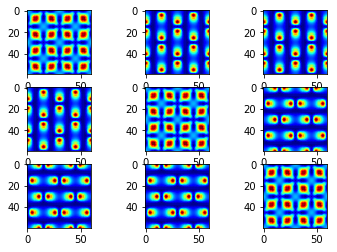

In [11]:
data2d_X = read_cube('/home/mk/qe_si/results/silicon.wf_K001_B005.cube')
data2d_X=transform_to_uc(data2d_X, 30)
data2d_X = translate(data2d_X, 1)
data2d_Y = read_cube('/home/mk/qe_si/results/silicon.wf_K003_B005.cube')
data2d_Y=transform_to_uc(data2d_Y, 30)
data2d_Y = translate(data2d_Y, 1)
data2d_Z = read_cube('/home/mk/qe_si/results/silicon.wf_K005_B005.cube')
data2d_Z=transform_to_uc(data2d_Z, 30)
data2d_Z = translate(data2d_Z, 1)
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3)
ax1.imshow(data2d_X[15,:,:], cmap='jet')
ax2.imshow(data2d_X[:,15,:], cmap='jet')
ax3.imshow(data2d_X[:,:,15], cmap='jet')
ax4.imshow(data2d_Y[15,:,:], cmap='jet')
ax5.imshow(data2d_Y[:,15,:], cmap='jet')
ax6.imshow(data2d_Y[:,:,15], cmap='jet')
ax7.imshow(data2d_Z[15,:,:], cmap='jet')
ax8.imshow(data2d_Z[:,15,:], cmap='jet')
ax9.imshow(data2d_Z[:,:,15], cmap='jet')
plt.show()